In [1]:
import numpy as np
import pyNNGP
import matplotlib.pyplot as plt
import ipywidgets as widgets

from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize

%matplotlib inline

## 2d Example
We consider a function on two inputs given by 
$$
f(x, y) = \sin(5xy) + \sin \left (5 \frac{x}{y} \right).
$$
We uniformly sample 3000 pairs of coordinates on $[0, 1]^2$, assuming that they are perturbed by $\mathcal{N} \left(0, \frac{1}{4} \right)$ noise.

In [2]:
import numpy as np
import pyNNGP

n = 500
nstar = 1500
m = 20
np.random.seed(5)
coords = np.random.uniform(0, 1, size=(n, 2))
s = np.argsort(coords[:,0])
coords = coords[s]

def f(x, y):
    return np.sin(5 * x * y) + np.sin(5 * x / y)

w = f(coords[:, 0], coords[:, 1])
eps = 0.25
noise = np.random.normal(0, eps, size=n)
y = w + noise

covModel = pyNNGP.SqExp(
    sigmaSq=0.5, 
    phi=5.0, phiUnifa=1.0, phiUnifb=50.0, phiTuning=1.0, 
    sigmaSqIGa=0.04, sigmaSqIGb=0.04
)

noiseModel = pyNNGP.ConstHomogeneousNoiseModel(0.01)

distFunc = pyNNGP.Euclidean()

nngp = pyNNGP.SeqNNGP(
    y, coords,
    nNeighbors=m,
    covModel=covModel,
    distFunc=distFunc,
    noiseModel=noiseModel
)

burn_in = 2000
nngp.sample(burn_in)

n_samples = 20
w_samples = []
for i in range(n_samples):
#     print("Iteration {}".format(i))
    nngp.sample(10)
    w_samples.append(np.copy(nngp.w))
w_samples = np.array(w_samples)
w_sample = np.mean(w_samples, axis=0)

w_map = nngp.predict(coords.T, 10)
w_map = w_map.reshape((n))

newcoords = np.random.uniform(0, 1, size=(nstar, 2))
s = np.argsort(newcoords[:,0])
newcoords = newcoords[s]

distMat = np.array([[np.linalg.norm(coords[x, :] - coords[y, :]) for x in range(n)] for y in range(n)])
covMat = np.array([[nngp.covModel.cov(distMat[x, y]) for x in range(n)] for y in range(n)]) + 0.5 * np.eye(n)
np.fill_diagonal(covMat, 1.0)
# invCovMat = np.linalg.inv(covMat)
crossdist = np.array([[np.linalg.norm(coords[y, :] - newcoords[x,:]) for y in range(n)] for x in range(nstar)])
crosscov = np.array([[nngp.covModel.cov(crossdist[x, y]) for y in range(n)] for x in range(nstar)])

wstar = f(newcoords[:, 0], newcoords[:, 1])
noisestar = np.random.normal(0, 0.25, size=nstar)
ystar = wstar + noisestar

wstar_sample = nngp.predict(newcoords.T, 20, 100)
wstar_sample = wstar_sample.reshape((nstar))

In [3]:
wstar_qf = [nngp.quadratic_form(crosscov[i, :], y) for i in range(nstar)]

In [4]:
wstar_dense = np.dot(crosscov, np.linalg.solve(covMat + 0.01 * np.eye(n), y))

Let's plot the resulting surface

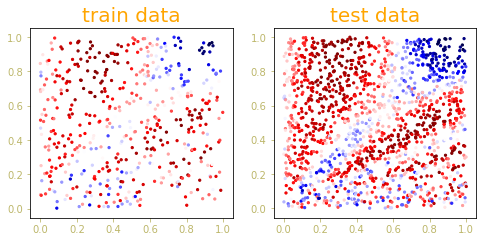

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))
for ax in axes:
    ax.tick_params(colors="darkkhaki")
i0 = axes[0].scatter(
    coords[:,0], coords[:,1],
    c=y, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)
# plt.colorbar(i0, axes[0])
axes[0].set_title("train data", fontsize=20, color="orange")
i1 = axes[1].scatter(
    newcoords[:,0], newcoords[:,1],
    c=ystar, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)    
# plt.colorbar(i1, axes[1])
axes[1].set_title("test data", fontsize=20, color="orange")
plt.show()

We will train an NNGP to model this surface. We specify the model below, using the squared exponential kernel and conditioning the likelihood of each training observation on at most 3 others.

In [6]:
@interact(i=widgets.IntSlider(min=0, max=len(w_samples)-1, value=0))
def f(i):
    fig, axes = plt.subplots(ncols=3, figsize=(14, 3.5))
    for ax in axes:
        ax.tick_params(colors="darkkhaki")
    i0 = axes[0].scatter(
        coords[:,0], coords[:,1], 
        c=w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i0, ax=axes[0])
    axes[0].set_title("train data", fontsize=20, color="orange")
    i1 = axes[1].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i], s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )    
    plt.colorbar(i1, ax=axes[1])
    axes[1].set_title("Estimates", fontsize=20, color="orange")
    i2 = axes[2].scatter(
        coords[:,0], coords[:,1],
        c=w_samples[i]-w, s=5,
        vmin=-1, vmax=1, cmap='seismic'
    )
    plt.colorbar(i2, ax=axes[2])
    axes[2].set_title("Residual", fontsize=20, color="orange")
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=19), Output()), _dom_classes=('widget-interact',…

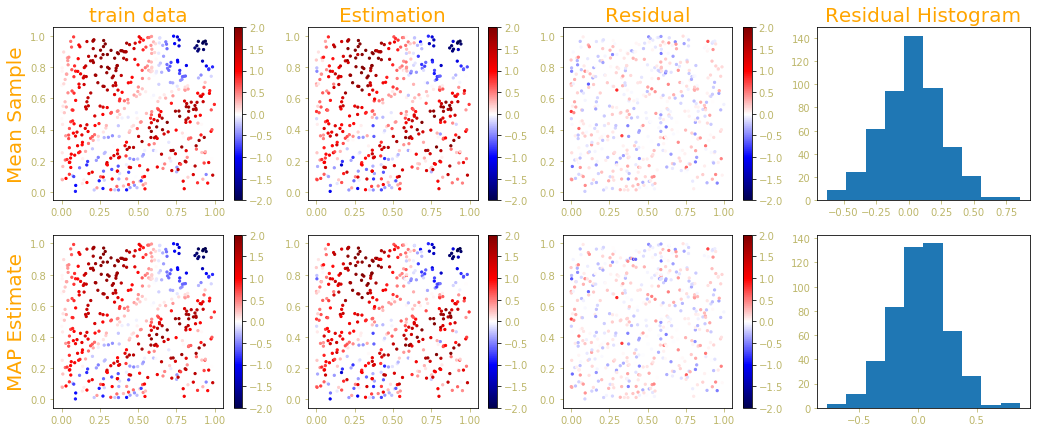

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(17.5, 7))
for axar in axes:
    for ax in axar:
        ax.tick_params(colors="darkkhaki")
"""
Sampled data
"""
i00 = axes[0,0].scatter(
    coords[:,0], coords[:,1], 
    c=w, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i00, ax=axes[0,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,0].set_title("train data", fontsize=20, color="orange")
axes[0,0].set_ylabel("Mean Sample", fontsize=20, color="orange")
i01 = axes[0,1].scatter(
    coords[:,0], coords[:,1],
    c=w_sample, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i01, ax=axes[0,1]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,1].set_title("Estimation", fontsize=20, color="orange")
i02 = axes[0,2].scatter(
    coords[:,0], coords[:,1],
    c=w_sample-w, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i02, ax=axes[0,2]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,2].set_title("Residual", fontsize=20, color="orange")
i03 = axes[0,3].hist(w_sample - w)
axes[0,3].set_title("Residual Histogram", fontsize=20, color="orange")
"""
MAP data
"""
i10 = axes[1,0].scatter(
    coords[:,0], coords[:,1], 
    c=w, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i10, ax=axes[1,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[1,0].set_ylabel("MAP Estimate", fontsize=20, color="orange")
i11 = axes[1,1].scatter(
    coords[:,0], coords[:,1],
    c=w_map, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i11, ax=axes[1,1]).ax.axes, "yticklabels"), color="darkkhaki")
i12 = axes[1,2].scatter(
    coords[:,0], coords[:,1],
    c=w_map-w, s=5,
    vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i12, ax=axes[1,2]).ax.axes, "yticklabels"), color="darkkhaki")
i13 = axes[1,3].hist(w_map - w)
plt.show()

Now we will normalize the coordinates to project onto the unit circle.

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GPR(kernel=kernel, alpha=eps ** 2, n_restarts_optimizer=9)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(coords, y)
# Make the prediction on the meshed x-axis (ask for MSE as well)
wstar_gp, sigma = gp.predict(newcoords, return_std=True)

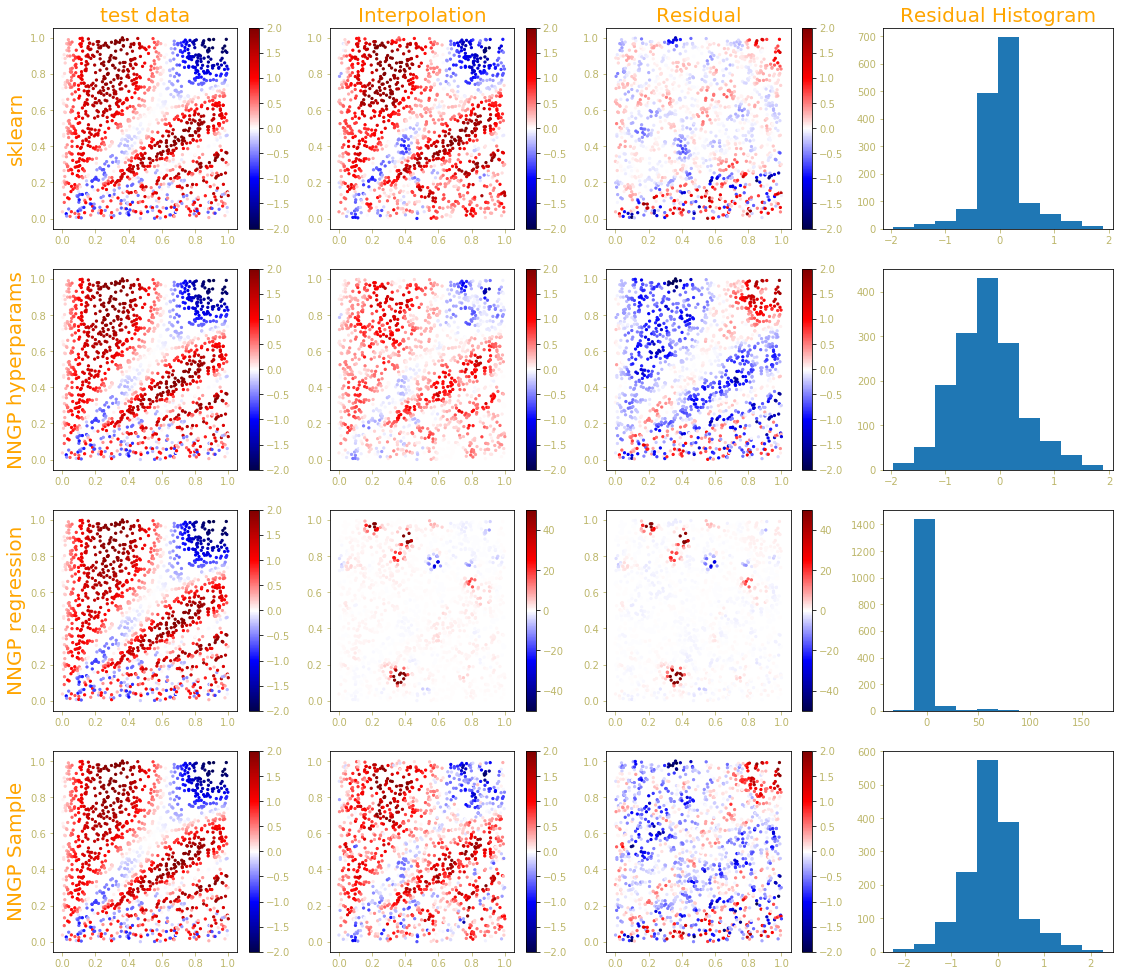

In [9]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(19, 17))
for axar in axes:
    for ax in axar:
        ax.tick_params(colors="darkkhaki")
"""
Full sklearn GPR
"""
i00 = axes[0,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i00, ax=axes[0,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,0].set_title("test data", fontsize=20, color="orange")
axes[0,0].set_ylabel("sklearn", fontsize=20, color="orange")
i01 = axes[0,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_gp, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i01, ax=axes[0,1]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,1].set_title("Interpolation", fontsize=20, color="orange")
i02 = axes[0,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_gp-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i02, ax=axes[0,2]).ax.axes, "yticklabels"), color="darkkhaki")
axes[0,2].set_title("Residual", fontsize=20, color="orange")
i03 = axes[0,3].hist(wstar_gp - wstar)
axes[0,3].set_title("Residual Histogram", fontsize=20, color="orange")
"""
Full GPR using NNGP trained hyperparameters
"""
i10 = axes[1,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i10, ax=axes[1,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[1,0].set_ylabel("NNGP hyperparams", fontsize=20, color="orange")
i11 = axes[1,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_dense, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i11, ax=axes[1,1]).ax.axes, "yticklabels"), color="darkkhaki")
i12 = axes[1,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_dense-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i12, ax=axes[1,2]).ax.axes, "yticklabels"), color="darkkhaki")
i13 = axes[1,3].hist(wstar_dense - wstar)
"""
Sparse GPR using NNGP trained hyperparameters
"""
i20 = axes[2,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i20, ax=axes[2,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[2,0].set_ylabel("NNGP regression", fontsize=20, color="orange")
i21 = axes[2,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_qf, s=5, vmin=-50, vmax=50, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i21, ax=axes[2,1]).ax.axes, "yticklabels"), color="darkkhaki")
i22 = axes[2,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_qf-wstar, s=5, vmin=-50, vmax=50, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i22, ax=axes[2,2]).ax.axes, "yticklabels"), color="darkkhaki")
# truncated_buckets = np.array([wstar_qf[i] - wstar[i] for i in range(nstar) if np.abs(wstar_qf[i] - wstar[i]) < 2])
# i23 = axes[2,3].hist(truncated_buckets)
i23 = axes[2,3].hist(wstar_qf - wstar)
"""
Sampled GPR using NNGP trained hyperparameters
"""
i30 = axes[3,0].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i30, ax=axes[3,0]).ax.axes, "yticklabels"), color="darkkhaki")
axes[3,0].set_ylabel("NNGP Sample", fontsize=20, color="orange")
i31 = axes[3,1].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_sample, s=5, vmin=-2, vmax=2, cmap='seismic'
)    
plt.setp(plt.getp(plt.colorbar(i31, ax=axes[3,1]).ax.axes, "yticklabels"), color="darkkhaki")
i32 = axes[3,2].scatter(
    newcoords[:,0], newcoords[:,1], c=wstar_sample-wstar, s=5, vmin=-2, vmax=2, cmap='seismic'
)
plt.setp(plt.getp(plt.colorbar(i32, ax=axes[3,2]).ax.axes, "yticklabels"), color="darkkhaki")
i33 = axes[3,3].hist(wstar_sample - wstar)
plt.show()

In [10]:
np.min(wstar_sample - wstar)

-2.2462768422408175